In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

11

In [ ]:
! ls 'drive/My Drive/NLP/팀플/study'

data_check.ipynb	   gtp2.ipynb			train_filtered.csv
gpt2_embedding.ipynb	   preprocessed_train_data.csv
gtp2_classification.ipynb  train.csv


In [ ]:
# hugging face install
!pip install transformers

In [ ]:
import io
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          GPT2LMHeadModel)

In [ ]:
import tqdm 

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import shutil

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cuda:0


**DATA 전처리**

In [ ]:
path = 'drive/My Drive/NLP/팀플/study/train_filtered.csv'

In [ ]:
## try balanced_case

In [ ]:
data = pd.read_csv(path)

# 중복 데이터 제거
data.drop_duplicates('Lyrics')

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
249943,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
249944,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
249945,celine dion,sorry for love,Pop,en,Forgive me for the things That I never said to...
249946,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


In [ ]:
data_drop = data.drop(['Artist', 'Song', 'Language'], axis=1)

In [ ]:
data_drop

,Genre,Lyrics
0,Rock,"It starts with pain, followed by hate\nFueled ..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...
2,Rock,"Biting the hand that feeds you, lying to the v..."
3,Rock,You say you know just who I am\nBut you can't ...
4,Rock,My heart is beating faster can't control these...
...,...,...
249943,R&B,I'm the best friend he's got I'd give him the ...
249944,Pop,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
249945,Pop,Forgive me for the things That I never said to...
249946,Indie,The day they found a cure for AIDS The day the...


In [ ]:
## over/under sampling

In [ ]:
# use only 10% total dataset
from sklearn.model_selection import train_test_split

a_data, b_data = train_test_split(data_drop, test_size=0.005, random_state=123)
train_data, test_data = train_test_split(b_data, test_size=0.3, random_state=123)

In [ ]:
## use total dataset
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3, random_state=123)

**Class**

In [ ]:
# make dataset
# for Dataloader
# dataset shape : {'label': 'Pop', 'text': "Give me attention Too much distance\nTo measure it out (...) Is as lucky as us"}

class SongLyrics(Dataset):  
    def __init__(self, data, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.texts = []
        self.labels = []

        for row in data['Lyrics']:
          self.texts.append(row)
        
        for gen in data['Genre']:
          self.labels.append(gen)

        self.lyrics_count = len(self.labels)
        
    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return {'text':self.texts[item],
                'label':self.labels[item]}

In [ ]:
## LSTM 모델
## from : https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0
## 잘 안 되면 위에 링크로 다시 만들기.

class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, n_class, dropout):
    super(TextLSTM, self).__init__()
    
    self.lstm = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=dropout,
              batch_first=True)

    self.dense = nn.Sequential(
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))

  def forward(self, hidden_and_cell, X):
    X = X.transpose(0, 1)
    outputs, hidden = self.lstm(X, hidden_and_cell)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    return self.dense(outputs)

In [ ]:
## 준현
class TextLSTM(nn.Module):
  # def __init__(self, input_size, hidden_size, num_layers, n_class, dropout):
  def __init__(self, input_size, hidden_size, n_class, dropout):
    super(TextLSTM, self).__init__()

    self.hidden_size = hidden_size

    # self.lstm1 = nn.LSTM(
    #           input_size=input_size,
    #           hidden_size=hidden_size*5,
    #           num_layers=1,
    #           dropout=0,
    #           batch_first=True)
    
    self.lstm2 = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.lstm3 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm4 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.dense = nn.Sequential(
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))

  def forward(self, hidden_and_cell, X):
    # X of shape N,L,Hin
    # hidden_and_cell zeros by default
    # outputs of shape N,L,Hout

    X = X.transpose(0, 1)

    outputs, (hn, cn) = self.lstm2(X)
    outputs, (hn, cn) = self.lstm3(outputs)
    outputs, (hn, cn) = self.lstm4(outputs)
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next


    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    return self.dense(outputs)



In [ ]:
## 준현
## change ReLU()
## https://cnvrg.io/pytorch-lstm/
class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, n_class, dropout):
    super(TextLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.relu = nn.ReLU()
    self.lstm2 = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.lstm3 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm4 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size*8,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm5 = nn.LSTM(
              input_size=hidden_size*8,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm6 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm7 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size*8,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm8 = nn.LSTM(
              input_size=hidden_size*8,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.dense = nn.Sequential(
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))


  def forward(self, hidden_and_cell, X):

    X = X.transpose(0, 1)

    outputs, (hn, cn) = self.lstm2(X)
    #outputs = self.relu(outputs)
    outputs, (hn, cn) = self.lstm3(outputs)
    #outputs = self.relu(outputs)
    outputs, (hn, cn) = self.lstm4(outputs)
    #outputs = self.relu(outputs)
    outputs, (hn, cn) = self.lstm5(outputs)
    outputs, (hn, cn) = self.lstm6(outputs)
    outputs, (hn, cn) = self.lstm7(outputs)
    outputs, (hn, cn) = self.lstm8(outputs)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    return self.dense(outputs)



**Hyperparameters**

In [ ]:
## hyperparameters
# lstm_classifier = TextLSTM(v_dim, hidden_size, num_layers, n_genre, dropout).to(device)

set_seed(123)
epochs = 3
batch_size = 16

lr = 0.0001
hidden_size = 128
num_layers = 4
# dropout = 0
dropout = 0.3

# v_dim?? dimention
v_dim = 768
n_genre = 10

####

# Pad or truncate text sequences to a specific length
## ! fix later
max_length = 500

model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'Rock': 0, 'Pop': 1, 'Metal': 2, 'Jazz': 3, 'Folk': 4, 'Indie': 5, 'R&B': 6, 'Hip-Hop': 7, 'Electronic': 8, 'Country': 9}
n_labels = len(labels_ids)

**DATA Embedding**

In [ ]:
## gpt2 tokenizer와 model 가져오기
## 기존의 방식

# Get model configuration.
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
# model >> gpt2_model
gpt2_model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
gpt2_model.resize_token_embeddings(len(tokenizer))
gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id
gpt2_model.output_hidden_states=True

# Load model to defined device.
gpt2_model.to(device)
print('Model loaded to `%s`'%device)


## new??
## model과 tokenizer 가져오기

#tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')
#gpt2_embedding = torch.hub.load('huggingface/pytorch-transformers', 'model', 'gpt2').to(device)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda:0`


In [ ]:

## train, test dataset 만들기
train_dataset = SongLyrics(train_data, truncate=True, gpt2_type="gpt2")
test_dataset = SongLyrics(test_data, truncate=True, gpt2_type="gpt2")


In [ ]:
class Gpt2ClassificationCollator(object):

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [ ]:

## dataset을 dataloader에 올리기

# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

## ?? collate_fn??
## gpt2_classification_collator의 역할도 잘 모르겠음.

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))


Created `train_dataloader` with 55 batches!

Created `eval_dataloader` with 24 batches!


In [ ]:

lstm_classifier = TextLSTM(v_dim, hidden_size, n_genre, dropout).to(device)
loss_func = nn.CrossEntropyLoss()
params = list(lstm_classifier.parameters())
optimizer = optim.Adam(params, lr=lr)


**Train**

Epoch [1/3], Train Loss: 2.1585, Train Acc: 0.4375, Valid Loss: 2.2144, Valid Acc: 0.4286
Epoch [2/3], Train Loss: 2.1541, Train Acc: 0.2500, Valid Loss: 2.3031, Valid Acc: 0.1429
Epoch [3/3], Train Loss: 2.0483, Train Acc: 0.5000, Valid Loss: 2.3049, Valid Acc: 0.1429


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Rock       0.50      0.05      0.09       157
         Pop       0.00      0.00      0.00       132
       Metal       0.05      0.03      0.04        30
        Jazz       0.00      0.00      0.00        13
        Folk       0.00      0.00      0.00        12
       Indie       0.00      0.00      0.00        14
         R&B       0.00      0.00      0.00         5
     Hip-Hop       0.00      0.00      0.00         5
  Electronic       0.00      0.00      0.00         2
     Country       0.01      0.60      0.02         5

    accuracy                           0.03       375
   macro avg       0.06      0.07      0.02       375
weighted avg       0.21      0.03      0.04       375



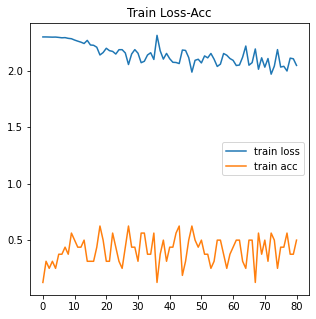

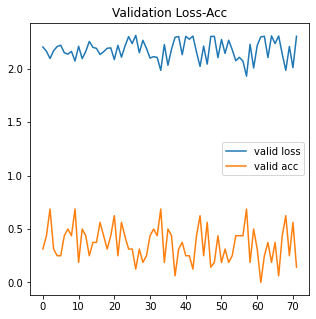

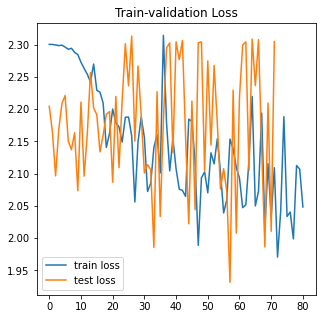

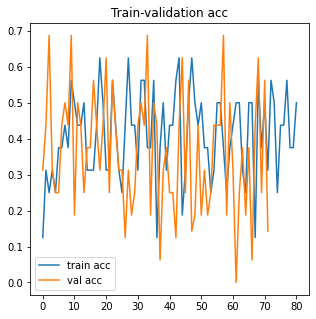

In [ ]:
num = round(len(train_dataloader)/len(test_dataloader))

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

predictions_labels = []
real_labels = []


for epoch in range(epochs):
  # b : epoch 안에서 몇 번째 batch인지
  b = 0
  ## 1. gpt2에 embedding하기.
  for batch in train_dataloader:
    b += 1
    # label_batch : 실제 label 값
    true_labels = batch['labels'].to(device) #.numpy().flatten().tolist()
    # print(true_labels)
    # batch_size = 32 / max_length = 60
    # tk_batch = batch['input_ids'] # torch.Size([32, 60])
    # sg_batch = batch['attention_mask'] # torch.Size([32, 60])

    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

    with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits = outputs[:2]
      # logits : 각 확률
      # print(logits.shape) # torch.Size([32, 10])
      hidden_state = outputs.hidden_states # torch 13개 (13개의 layer)

    # embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)
    embedded_tokens = hidden_state[0]

    ## torch.zeros(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor
    # ! embedded_token이 무엇인지 확인해야겠네.
    hidden = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    cell = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    
    ## juwoo
    lstm_classifier.train()
    output = lstm_classifier.forward((hidden, cell), embedded_tokens)
    optimizer.zero_grad()
    loss = loss_func(output, true_labels)
    loss.backward()
    optimizer.step()


    if b%num == 0:
      train_loss_list.append(float(loss.detach().cpu().data))
      pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
      acc = np.mean(pred == true_labels.detach().cpu().numpy().flatten())
      train_acc_list.append(float(acc))



  # test 진행하기.
  for batch in test_dataloader:
    # label_batch : 실제 label 값
    true_labels = batch['labels'].to(device) # .numpy().flatten().tolist()
    # real_labels += batch['labels'].numpy().flatten().tolist() #for f1-score

    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

    with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits = outputs[:2]
      # logits : 각 확률
      # print(logits.shape) # torch.Size([32, 10])
      hidden_state = outputs.hidden_states # tuple 13개 (13개의 layer)
      # hidden_state_01 = hidden_state[0]
      # print(hidden_state_01.shape)

    # embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)
      embedded_tokens = hidden_state[12]

      ## juwoo
      lstm_classifier.eval()
      output = lstm_classifier.forward((hidden, cell), embedded_tokens)
      optimizer.zero_grad()
      loss = loss_func(output, true_labels)

    ####
    # predictions_labels += output.argmax(axis=-1).flatten().tolist()

    val_loss_list.append(float(loss.detach().cpu().data))
    pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
    acc = np.mean(pred == true_labels.detach().cpu().numpy().flatten())
    val_acc_list.append(float(acc))

    
  print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
                      .format(epoch+1, epochs, train_loss_list[-1], train_acc_list[-1], val_loss_list[-1], val_acc_list[-1]))
  


###### ###


# Tracking variables
predictions_labels = []
real_labels = []
#total loss for this epoch.
total_loss = 0

for batch in test_dataloader:
  # label_batch : 실제 label 값
  true_labels = batch['labels'].to(device) # .numpy().flatten().tolist()
  real_labels += batch['labels'].numpy().flatten().tolist() #for f1-score

  batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

  with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits = outputs[:2]
      # logits : 각 확률
      # print(logits.shape) # torch.Size([32, 10])
      hidden_state = outputs.hidden_states # tuple 13개 (13개의 layer)
      # hidden_state_01 = hidden_state[0]
      # print(hidden_state_01.shape)

    # embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)
      embedded_tokens = hidden_state[0]

      ## 
      lstm_classifier.eval()
      output = lstm_classifier.forward((hidden, cell), embedded_tokens)
      optimizer.zero_grad()
      loss = loss_func(output, true_labels)
      predict_content = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()

      # update list
      predictions_labels += predict_content



## print f1-score
# Create the evaluation report.
evaluation_report = classification_report(real_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)



## plot
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.title('Train Loss-Acc')
plt.plot(train_loss_list, label='train loss')
plt.plot(train_acc_list, label='train acc')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.title('Validation Loss-Acc')
plt.plot(val_loss_list, label='valid loss')
plt.plot(val_acc_list, label='valid acc')
plt.legend()
plt.show()





plt.figure(figsize=(5,5))
plt.title('Train-validation Loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='test loss')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.title('Train-validation acc')
plt.plot(train_acc_list, label='train acc')
plt.plot(val_acc_list, label='val acc')
plt.legend()
plt.show()




# **아래로는 체크한 거**

In [ ]:

# Tracking variables
predictions_labels = []
real_labels = []
#total loss for this epoch.
total_loss = 0

for batch in test_dataloader:
  # label_batch : 실제 label 값
  true_labels = batch['labels'].to(device) # .numpy().flatten().tolist()
  real_labels += batch['labels'].numpy().flatten().tolist() #for f1-score

  batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

  with torch.no_grad():
      outputs = gpt2_model(**batch, output_hidden_states=True)
      loss, logits = outputs[:2]
      # logits : 각 확률
      # print(logits.shape) # torch.Size([32, 10])
      hidden_state = outputs.hidden_states # tuple 13개 (13개의 layer)
      # hidden_state_01 = hidden_state[0]
      # print(hidden_state_01.shape)

    # embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)
      embedded_tokens = hidden_state[0]

      ## juwoo
      lstm_classifier.eval()
      output = lstm_classifier.forward((hidden, cell), embedded_tokens)
      optimizer.zero_grad()
      loss = loss_func(output, true_labels)

      predict_content = logits.argmax(axis=-1).flatten().tolist()

      # update list
      predictions_labels += predict_content

      #predictions_labels += output.argmax(axis=-1).flatten().tolist()



# print f1-score
# Create the evaluation report.
evaluation_report = classification_report(real_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

              precision    recall  f1-score   support

        Rock       0.50      0.00      0.01      3207
         Pop       0.00      0.00      0.00      2581
       Metal       0.00      0.00      0.00       573
        Jazz       0.00      0.00      0.00       417
        Folk       0.00      0.00      0.00       251
       Indie       0.00      0.00      0.00       223
         R&B       0.00      0.00      0.00        80
     Hip-Hop       0.00      0.00      0.00        54
  Electronic       0.00      0.00      0.00        50
     Country       0.01      0.98      0.02        63

    accuracy                           0.01      7499
   macro avg       0.05      0.10      0.00      7499
weighted avg       0.21      0.01      0.00      7499



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## em [0]일 때,
print(real_labels)
print(predictions_labels)

## new data
## hidden [0]
## 0.5
## f1-score bad
## dataset = 0.01

[4, 1, 0, 0, 0, 3, 1, 1, 5, 1, 2, 0, 4, 8, 0, 1, 2, 1, 1, 0, 4, 3, 0, 9, 1, 2, 0, 1, 0, 3, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 5, 3, 1, 1, 0, 1, 0, 2, 0, 0, 1, 1, 0, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 5, 0, 0, 0, 1, 0, 1, 0, 2, 0, 4, 0, 1, 2, 1, 0, 0, 0, 1, 7, 1, 3, 1, 0, 0, 5, 1, 0, 4, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 5, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 3, 2, 1, 2, 0, 0, 0, 1, 0, 0, 3, 1, 1, 2, 0, 0, 0, 5, 0, 1, 6, 3, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 8, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 5, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 8, 3, 0, 0, 0, 0, 4, 4, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 1, 6, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 8, 0, 0, 4, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 3, 6, 0, 3, 0, 1, 0, 5, 0, 0, 1, 1, 0, 1, 0, 0, 0, 6, 0, 2, 1, 2, 1, 0, 1, 0, 1, 0, 1, 

In [ ]:
## em [0]일 때,
print(real_labels)
print(predictions_labels)

## new data
## hidden [0]
## 0.28 > 0.4286(나머지 4번)
## f1-score bad
## dataset = 0.005

[2, 0, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 1, 0, 1, 5, 1, 0, 0, 0, 4, 0, 3, 0, 9, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 2, 1, 0, 7, 0, 2, 1, 0, 4, 1, 4, 1, 0, 1, 6, 4, 0, 1, 0, 1, 9, 3, 1, 0, 1, 1, 0, 7, 0, 0, 0, 2, 1, 1, 1, 0, 5, 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 4, 5, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 2, 1, 1, 2, 0, 1, 3, 2, 1, 5, 1, 1, 1, 0, 1, 0, 4, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 6, 5, 3, 1, 1, 9, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 1, 1, 2, 1, 0, 1, 4, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 7, 8, 3, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 5, 0, 0, 5, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 0, 1, 5, 1, 0, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 4, 3, 4, 1, 1, 0, 1, 1, 1, 0, 0, 6, 8, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
## em [0]일 때,
print(real_labels)
print(predictions_labels)

## new data
## hidden [0]
## 4286 반복 중
## f1-score bad
## dataset = 0.005
# lstm 16 > 4 > 8 > 1

In [ ]:
## em [0]일 때,
print(real_labels)
print(predictions_labels)

## new data
## hidden [0]
## 4286
## f1-score bad
## predict label = 3이 압도적
## dataset = 0.005
# lstm 2 > 1

[2, 0, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 1, 0, 1, 5, 1, 0, 0, 0, 4, 0, 3, 0, 9, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 2, 1, 0, 7, 0, 2, 1, 0, 4, 1, 4, 1, 0, 1, 6, 4, 0, 1, 0, 1, 9, 3, 1, 0, 1, 1, 0, 7, 0, 0, 0, 2, 1, 1, 1, 0, 5, 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 4, 5, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 2, 1, 1, 2, 0, 1, 3, 2, 1, 5, 1, 1, 1, 0, 1, 0, 4, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 6, 5, 3, 1, 1, 9, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 1, 1, 2, 1, 0, 1, 4, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 7, 8, 3, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 5, 0, 0, 5, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 0, 1, 5, 1, 0, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 4, 3, 4, 1, 1, 0, 1, 1, 1, 0, 0, 6, 8, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
def count_num(list):
  #labels = ['0', '1', '2','3','4','5','6','7','8','9']
  new_list = []
  for a in range(10):
    new_list.append(list.count(a))
  return new_list


In [ ]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 8 > 1
## hidden [0]
## 4286 5개 전부
## f1-score bad
## predict label = 3이 압도적
## dataset = 0.005

[2, 0, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 1, 0, 1, 5, 1, 0, 0, 0, 4, 0, 3, 0, 9, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 2, 1, 0, 7, 0, 2, 1, 0, 4, 1, 4, 1, 0, 1, 6, 4, 0, 1, 0, 1, 9, 3, 1, 0, 1, 1, 0, 7, 0, 0, 0, 2, 1, 1, 1, 0, 5, 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 4, 5, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 2, 1, 1, 2, 0, 1, 3, 2, 1, 5, 1, 1, 1, 0, 1, 0, 4, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 6, 5, 3, 1, 1, 9, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 1, 1, 2, 1, 0, 1, 4, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 7, 8, 3, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 5, 0, 0, 5, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 0, 1, 5, 1, 0, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 4, 3, 4, 1, 1, 0, 1, 1, 1, 0, 0, 6, 8, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 8 > 1
## hidden [12]
## 4286 5개 전부
## f1-score bad
## predict label = 3이 압도적
## dataset = 0.005

In [ ]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 8 > 1
## epoch 3
## hidden [1]
## 5714 > 4286 > 4286
## f1-score bad
## predict label = 3이 압도적
## dataset = 0.005

[2, 0, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 1, 0, 1, 5, 1, 0, 0, 0, 4, 0, 3, 0, 9, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 2, 1, 0, 7, 0, 2, 1, 0, 4, 1, 4, 1, 0, 1, 6, 4, 0, 1, 0, 1, 9, 3, 1, 0, 1, 1, 0, 7, 0, 0, 0, 2, 1, 1, 1, 0, 5, 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 4, 5, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 2, 1, 1, 2, 0, 1, 3, 2, 1, 5, 1, 1, 1, 0, 1, 0, 4, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 6, 5, 3, 1, 1, 9, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 1, 1, 2, 1, 0, 1, 4, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 7, 8, 3, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 5, 0, 0, 5, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 0, 1, 5, 1, 0, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 4, 3, 4, 1, 1, 0, 1, 1, 1, 0, 0, 6, 8, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 8 > 1
## epoch 3
## hidden [12]
## 5714 > 4286 > 4286
## f1-score bad
## predict label = 3이 압도적
## dataset = 0.005

[2, 0, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 1, 0, 1, 5, 1, 0, 0, 0, 4, 0, 3, 0, 9, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 2, 1, 0, 7, 0, 2, 1, 0, 4, 1, 4, 1, 0, 1, 6, 4, 0, 1, 0, 1, 9, 3, 1, 0, 1, 1, 0, 7, 0, 0, 0, 2, 1, 1, 1, 0, 5, 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 4, 5, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 2, 1, 1, 2, 0, 1, 3, 2, 1, 5, 1, 1, 1, 0, 1, 0, 4, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 6, 5, 3, 1, 1, 9, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 1, 1, 2, 1, 0, 1, 4, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 7, 8, 3, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 5, 0, 0, 5, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 0, 1, 5, 1, 0, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 4, 3, 4, 1, 1, 0, 1, 1, 1, 0, 0, 6, 8, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 1
## epoch 3
## hidden [0]
## 5714 > 4286 > 4286
## f1-score bad
## predict label = 3이 압도적
## dataset = 0.005

[2, 0, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 1, 0, 1, 5, 1, 0, 0, 0, 4, 0, 3, 0, 9, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 2, 1, 0, 7, 0, 2, 1, 0, 4, 1, 4, 1, 0, 1, 6, 4, 0, 1, 0, 1, 9, 3, 1, 0, 1, 1, 0, 7, 0, 0, 0, 2, 1, 1, 1, 0, 5, 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 4, 5, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 2, 1, 1, 2, 0, 1, 3, 2, 1, 5, 1, 1, 1, 0, 1, 0, 4, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 6, 5, 3, 1, 1, 9, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 1, 1, 2, 1, 0, 1, 4, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 7, 8, 3, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 5, 0, 0, 5, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 0, 1, 5, 1, 0, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 4, 3, 4, 1, 1, 0, 1, 1, 1, 0, 0, 6, 8, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 4 > 2 > 8 >>> lstm 7개
## epoch 3
## hidden [0]
## 1429 > 0 > 0

[2, 0, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 1, 0, 1, 5, 1, 0, 0, 0, 4, 0, 3, 0, 9, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 2, 1, 0, 7, 0, 2, 1, 0, 4, 1, 4, 1, 0, 1, 6, 4, 0, 1, 0, 1, 9, 3, 1, 0, 1, 1, 0, 7, 0, 0, 0, 2, 1, 1, 1, 0, 5, 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 4, 5, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 2, 1, 1, 2, 0, 1, 3, 2, 1, 5, 1, 1, 1, 0, 1, 0, 4, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 6, 5, 3, 1, 1, 9, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 1, 1, 2, 1, 0, 1, 4, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 7, 8, 3, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 5, 0, 0, 5, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 0, 1, 5, 1, 0, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 4, 3, 4, 1, 1, 0, 1, 1, 1, 0, 0, 6, 8, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
print(real_labels)
print(predictions_labels)

new_list = count_num(predictions_labels)
print(new_list)

## 위에랑 똑같은데 리셋하고 학습한 것.
## 4 > 2 > 8 >>> lstm 7개
## epoch 3
## hidden [0]
## 4286 > 1429 > 1429 

[2, 0, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 1, 0, 1, 5, 1, 0, 0, 0, 4, 0, 3, 0, 9, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 5, 0, 2, 1, 0, 7, 0, 2, 1, 0, 4, 1, 4, 1, 0, 1, 6, 4, 0, 1, 0, 1, 9, 3, 1, 0, 1, 1, 0, 7, 0, 0, 0, 2, 1, 1, 1, 0, 5, 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 4, 5, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 2, 1, 1, 2, 0, 1, 3, 2, 1, 5, 1, 1, 1, 0, 1, 0, 4, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 6, 5, 3, 1, 1, 9, 1, 4, 1, 1, 0, 0, 5, 0, 0, 1, 1, 1, 2, 1, 0, 1, 4, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 7, 8, 3, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 5, 0, 0, 5, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 0, 1, 5, 1, 0, 6, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 4, 3, 4, 1, 1, 0, 1, 1, 1, 0, 0, 6, 8, 7, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
#https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0
# 이거 바탕으로 loss-acc 출력하는 거 다시 짜기.

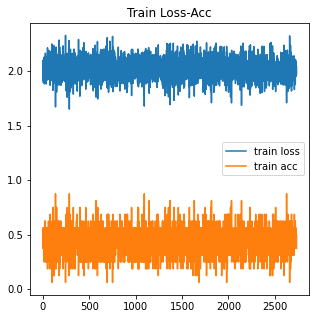

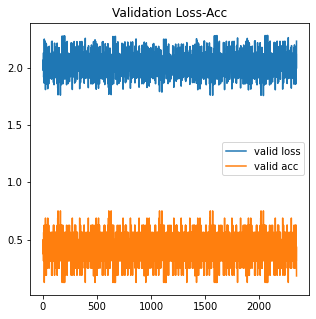

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.title('Train Loss-Acc')
plt.plot(train_loss_list, label='train loss')
plt.plot(train_acc_list, label='train acc')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.title('Validation Loss-Acc')
plt.plot(val_loss_list, label='valid loss')
plt.plot(val_acc_list, label='valid acc')
plt.legend()
plt.show()

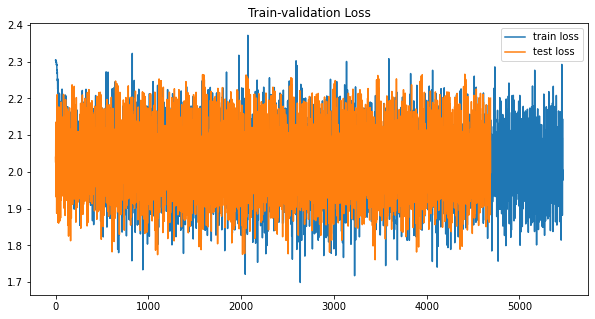

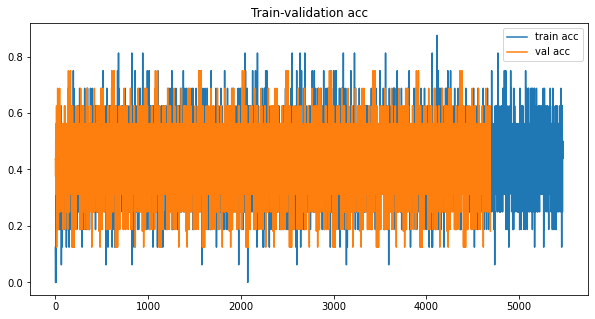

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title('Train-validation Loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='test loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('Train-validation acc')
plt.plot(train_acc_list, label='train acc')
plt.plot(val_acc_list, label='val acc')
plt.legend()
plt.show()